In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")

100%|██████████| 50.9M/50.9M [00:00<00:00, 229MB/s]

Extracting files...


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

In [4]:
print(os.listdir(path))

['MiningProcess_Flotation_Plant_Database.csv']


In [5]:
csv_path = os.path.join(path, "MiningProcess_Flotation_Plant_Database.csv")
df = pd.read_csv(csv_path)

In [6]:
df.shape

(737453, 24)

In [7]:
# Check the first few rows
print("First 5 rows of the dataset:")
print(df.head())
print("\n")

First 5 rows of the dataset:
                  date % Iron Feed % Silica Feed Starch Flow Amina Flow  \
0  2017-03-10 01:00:00        55,2         16,98     3019,53    557,434   
1  2017-03-10 01:00:00        55,2         16,98     3024,41    563,965   
2  2017-03-10 01:00:00        55,2         16,98     3043,46    568,054   
3  2017-03-10 01:00:00        55,2         16,98     3047,36    568,665   
4  2017-03-10 01:00:00        55,2         16,98     3033,69    558,167   

  Ore Pulp Flow Ore Pulp pH Ore Pulp Density Flotation Column 01 Air Flow  \
0       395,713     10,0664             1,74                      249,214   
1       397,383     10,0672             1,74                      249,719   
2       399,668      10,068             1,74                      249,741   
3       397,939     10,0689             1,74                      249,917   
4       400,254     10,0697             1,74                      250,203   

  Flotation Column 02 Air Flow  ... Flotation Column 07 A

In [8]:
# Check data types and missing values
print("Data types and missing values:")
print(df.info())
print("\n")

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flo

In [9]:
# Summary statistics
print("Summary statistics:")
print(df.describe())
print("\n")

Summary statistics:
                       date % Iron Feed % Silica Feed Starch Flow Amina Flow  \
count                737453      737453        737453      737453     737453   
unique                 4097         278           293      409317     319416   
top     2017-09-09 23:00:00       64,03          6,26      2562,5    534,668   
freq                    180      142560        142560         690        959   

       Ore Pulp Flow Ore Pulp pH Ore Pulp Density  \
count         737453      737453           737453   
unique        180189      131143           105805   
top          402,246     10,0591             1,75   
freq            1735        1509             3214   

       Flotation Column 01 Air Flow Flotation Column 02 Air Flow  ...  \
count                        737453                       737453  ...   
unique                        43675                        80442  ...   
top                         299,927                      255,322  ...   
freq                 

In [10]:
# Check for missing values
print("Missing values count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print(f"Total missing values: {df.isnull().sum().sum()}")
print("\n")

Missing values count:
Series([], dtype: int64)
Total missing values: 0




In [11]:
# Fix data format issues - replace commas with dots and convert to float
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = df[column].str.replace(',', '.').astype(float)
        except:
            pass

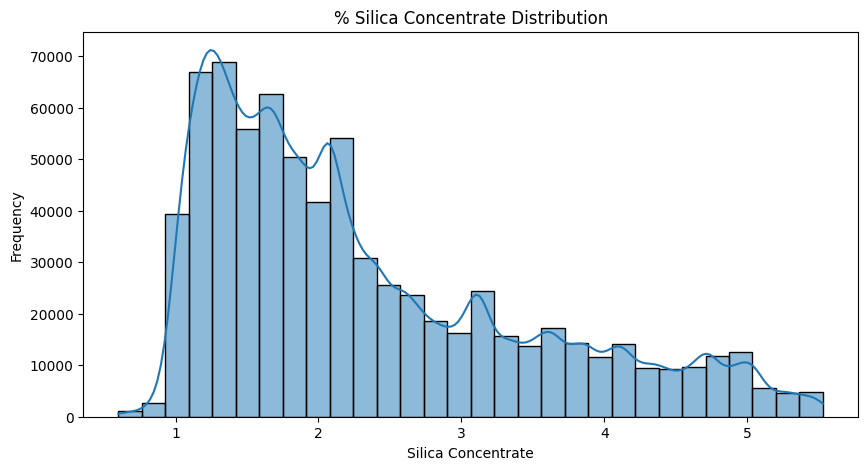

In [12]:
# Histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10,5))
sns.histplot(df['% Silica Concentrate'], bins=30, kde=True)
plt.title('% Silica Concentrate Distribution')
plt.xlabel('Silica Concentrate')
plt.ylabel('Frequency')
plt.show()

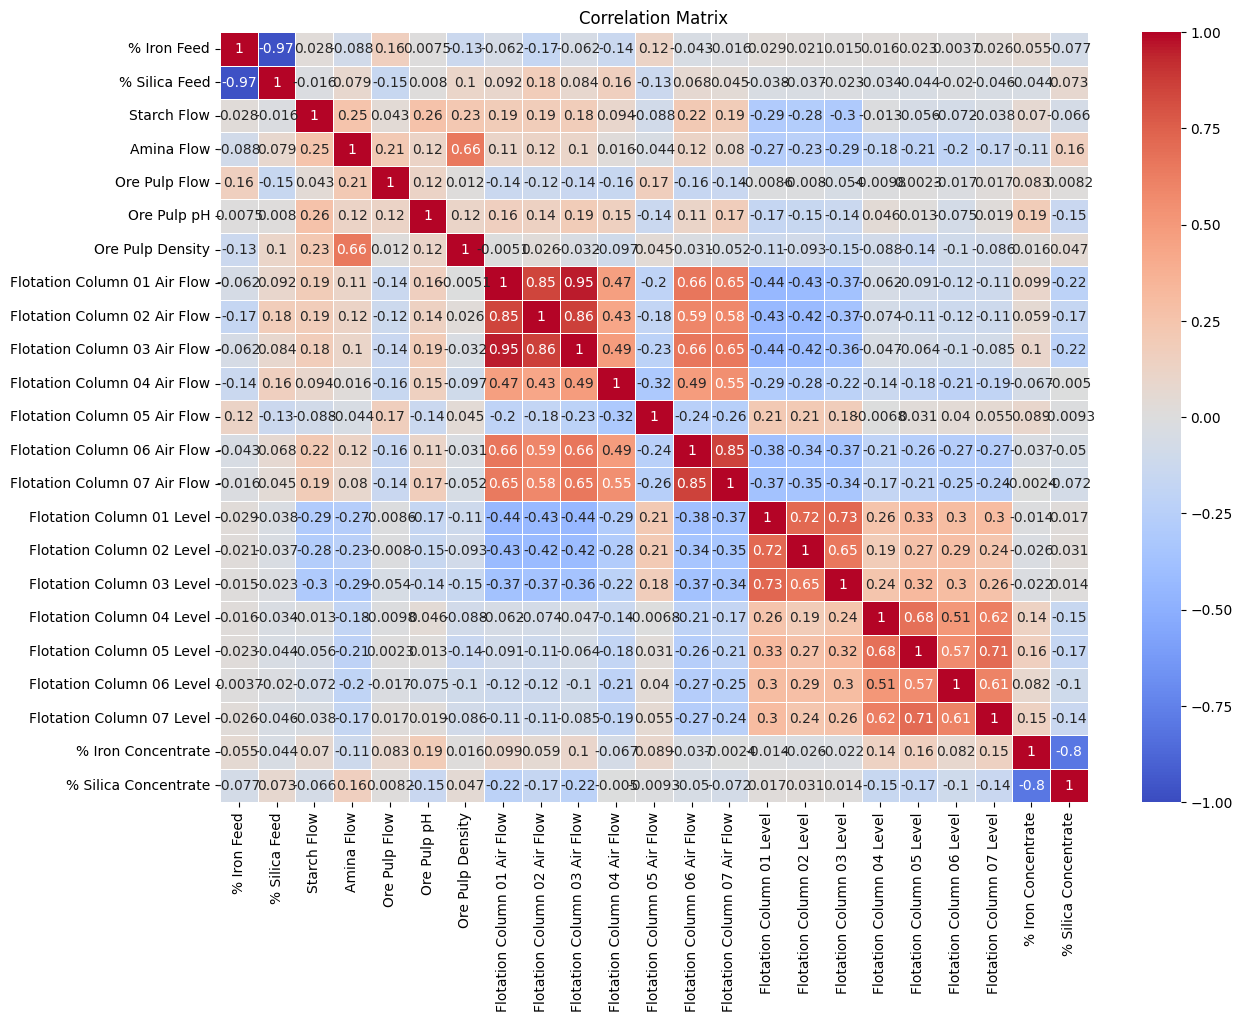

In [21]:
# Convert 'date' column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Extract only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Optional: create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmax=1, vmin=-1)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

In [17]:
target_column = '% Silica Concentrate'

In [22]:
# Define features and target
X = df.drop(target_column, axis=1)
y = df[target_column]

In [23]:
# Remove any columns that still have NaN values
X = X.select_dtypes(include=['number'])  # Keep only numeric columns
X = X.fillna(X.median())  # Final cleaning of any remaining NaN

In [26]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [27]:
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (663707, 22)
Test set size: (73746, 22)


In [28]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(663707, 22)
(73746, 22)


In [30]:
print(X_train_scaled)

[[-2.11590839  2.38667244 -0.86445737 ...  0.19518922  0.61530518
   1.81442074]
 [ 0.08835058 -0.16339684 -2.05353386 ... -0.37728153 -0.17814305
   0.36670875]
 [ 0.09222791 -0.39255054 -1.41581409 ... -0.40949643  0.25163013
   0.01818549]
 ...
 [-0.21795805 -0.0444132  -1.53636597 ... -1.12424223 -1.42309099
  -2.60914367]
 [ 0.38108858 -0.26034648  0.28814007 ...  0.58578374  0.25802444
   0.59905759]
 [-0.53977598  0.27434546 -0.33379308 ... -0.01395176 -0.42355276
   0.77778746]]


In [31]:
model = RandomForestRegressor(random_state=42)

In [32]:
# Train and evaluate the model

print(f"Training on the train dataset using Random Forest.....")
model.fit(X_train_scaled, y_train)


# Prediction on the validation sets
print(f"Evaluating on the test dataset using Random Forest.....")
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

Training on the train dataset using Random Forest.....
Evaluating on the test dataset using Random Forest.....


In [33]:
print(f"Random Forest Testing Results:")
print(f" Testing RMSE: {test_rmse:.4f}")
print(f" Testing MAE: {test_mae:.4f}")
print(f" Testing R²: {test_r2:.4f}")

Random Forest Testing Results:
 Testing RMSE: 0.0420
 Testing MAE: 0.0087
 Testing R²: 0.9986


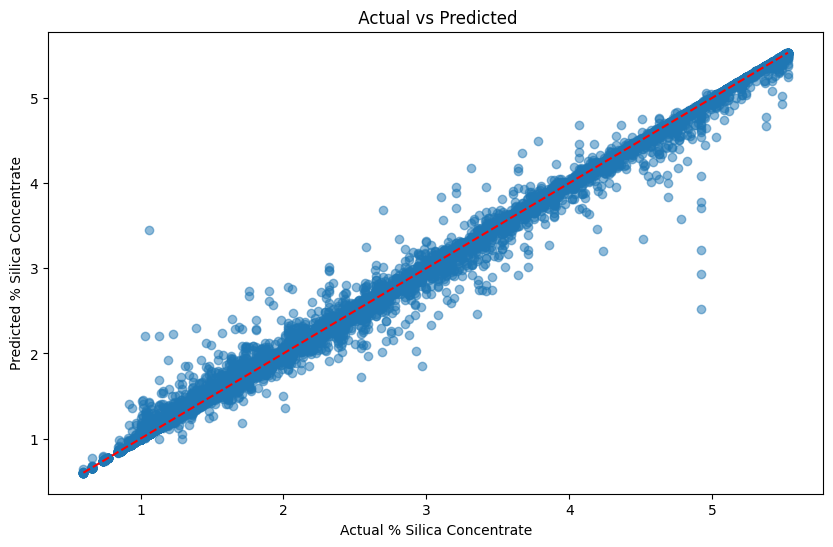

In [34]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual % Silica Concentrate')
plt.ylabel('Predicted % Silica Concentrate')
plt.title(f' Actual vs Predicted')
plt.savefig('actual_vs_predicted.png')
plt.show()
plt.close()

Top 15 most important features:
                         Feature  Importance
21            % Iron Concentrate    0.734637
1                  % Silica Feed    0.040667
0                    % Iron Feed    0.035130
5                    Ore Pulp pH    0.025974
16     Flotation Column 03 Level    0.019346
7   Flotation Column 01 Air Flow    0.018360
3                     Amina Flow    0.018031
6               Ore Pulp Density    0.015549
10  Flotation Column 04 Air Flow    0.012943
11  Flotation Column 05 Air Flow    0.011630
14     Flotation Column 01 Level    0.011496
2                    Starch Flow    0.009347
15     Flotation Column 02 Level    0.007913
4                  Ore Pulp Flow    0.006531
18     Flotation Column 05 Level    0.006495


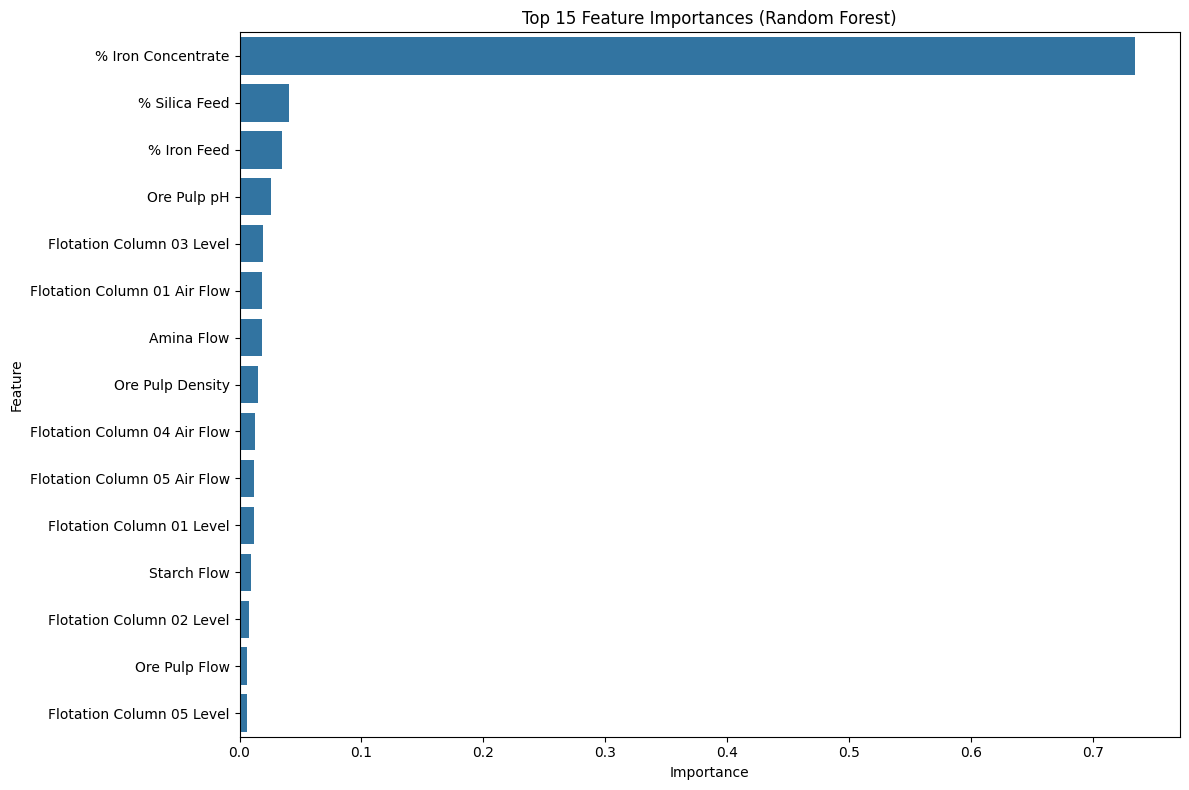

In [35]:
# Feature Importance for Random Forest model

# Get feature importances from your trained model `rf`
feature_importances = model.feature_importances_
feature_names = X.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 15 features
print("Top 15 most important features:")
print(importance_df.head(15))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()
